In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch

#### Define the linear dynamic system

In [38]:
from DynamicSystem import Linear_Dynamic_System
import os
import numpy.random as nrd
from MOR import AE_Reduced_System, POD_Reduced_System
import numpy as np
from util import mse

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# define the dimension of the system
dim_x = 50 # dimension of inate state
dim_y = 1 # dimension of output
dim_u = 5 # dimention of input
time_steps = 200 # time steps to be generated
dim_x_reduct = 10 # dimension after MOR


original_sys = Linear_Dynamic_System(dim_x, dim_u, dim_y) # define a system


# randomly generate the input u and x0
u = np.random.randn(dim_u, time_steps)
x0 = np.random.randn(dim_x, 1)

# generate data
x, y = original_sys.gen(x0, u, time_steps)
print("the shape of x: ", x.shape)
print("the shape of y: ", y.shape)

the shape of x:  (50, 200)
the shape of y:  (1, 200)


In [39]:
ae_sys = AE_Reduced_System(original_sys, dim_x_reduct, nonlinear=True)
reconst_x_AE, reconst_y_AE = ae_sys.fit(x)

import importlib
import MOR
importlib.reload(MOR)

pod_sys = MOR.POD_Reduced_System(original_sys, dim_x_reduct)
reconst_x_POD, reconst_y_POD = pod_sys.fit(x)

#### Prediction on training set

In [ ]:
# training set

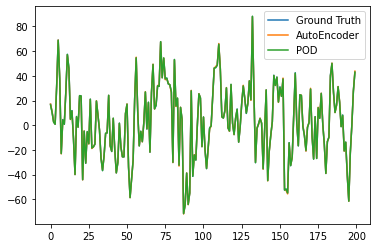

In [40]:
plt.plot(y.reshape(-1), label="Ground Truth")
plt.plot(reconst_y_AE.reshape(-1), label="AutoEncoder")
plt.plot(reconst_y_POD.reshape(-1), label='POD')
plt.legend()

Text(0.5, 1.0, 'POD')

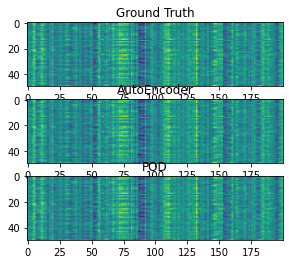

In [41]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.imshow(x)
ax1.set_title("Ground Truth")
ax2.imshow(reconst_x_AE)
ax2.set_title("AutoEncoder")
ax3.imshow(reconst_x_POD)
ax3.set_title("POD")

#### Prediction on test set

In [ ]:
# test set

In [49]:
u_test = np.random.randn(dim_u, time_steps)
true_x = np.random.randn(dim_x)

In [50]:
# true_x = x[:, -1]
cur_x = ae_sys.compress(true_x)
true_ys, ae_ys = [], []
true_xs, ae_xs = [], []
for i in range(time_steps):
    true_x, true_y = original_sys.step(true_x, u_test[:, i])
    new_x, new_y = ae_sys.step(cur_x, u_test[:, i])
    # print(true_y.shape, new_y.shape)
    true_ys.append(true_y[0])
    true_xs.append(true_x)
    ae_ys.append(new_y[0])
    ae_xs.append(ae_sys.decompress(new_x))
    cur_x = new_x

In [51]:
# true_x = x[:, -1]
cur_x = pod_sys.compress(true_x)
true_ys, pod_ys = [], []
true_xs, pod_xs = [], []
for i in range(time_steps):
    true_x, true_y = original_sys.step(true_x, u_test[:, i])
    new_x, new_y = pod_sys.step(cur_x, u_test[:, i])
    # print(true_y.shape, new_y.shape)
    true_ys.append(true_y[0])
    true_xs.append(true_x)
    pod_ys.append(new_y[0])
    pod_xs.append(pod_sys.decompress(new_x))
    cur_x = new_x

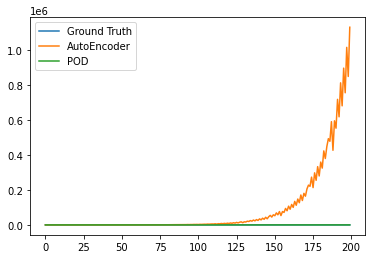

In [52]:
plt.plot(true_ys, label="Ground Truth")
plt.plot(ae_ys, label="AutoEncoder")
plt.plot(pod_ys, label="POD")
plt.legend()

Text(0.5, 1.0, 'POD')

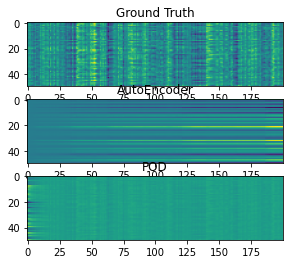

In [46]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.imshow(np.stack(true_xs).T)
ax1.set_title("Ground Truth")
ax2.imshow(np.stack(ae_xs).T)
ax2.set_title("AutoEncoder")
ax3.imshow(np.stack(pod_xs).T)
ax3.set_title('POD')

#### MSE change alongside different reduction dimension

In [47]:
def get_test_sets(x0, u_test, original_sys, time_steps): 
    true_xs, true_ys = [], []
    true_x = x0
    for i in range(time_steps):
        true_x, true_y = original_sys.step(true_x, u_test[:, i])
        true_ys.append(true_y[0])
        true_xs.append(true_x)
    true_xs = np.stack(true_xs).T
    true_ys = np.array(true_ys)
    return true_xs, true_ys


def get_test_predict(x0, u_test, reduction_sys, time_steps):
    new_x = reduction_sys.compress(x0)
    pred_xs, pred_ys = [], []
    for i in range(time_steps):
        new_x, new_y = reduction_sys.step(new_x, u_test[:, i])
        # print(true_y.shape, new_y.shape)
        pred_ys.append(new_y[0])
        pred_xs.append(reduction_sys.decompress(new_x))
    pred_xs = np.stack(pred_xs).T
    pred_ys = np.array(pred_ys)
    return pred_xs, pred_ys

In [48]:
dim_x_reduct_list = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

mse_train_list_x_ae = []
mse_test_list_x_ae = []
mse_train_list_y_ae = []
mse_test_list_y_ae = []

mse_train_list_x_pod = []
mse_test_list_x_pod = []
mse_train_list_y_pod = []
mse_test_list_y_pod = []

test_xs, test_ys = get_test_sets(true_x, u_test, original_sys, time_steps)


for dim_reduc in dim_x_reduct_list:
    ae_sys = AE_Reduced_System(original_sys, dim_reduc, nonlinear=True)
    reconst_x_AE, reconst_y_AE = ae_sys.fit(x)
    mse_train_list_y_ae.append(mse(y, reconst_y_AE))
    mse_train_list_x_ae.append(mse(x, reconst_x_AE))

    pod_sys = MOR.POD_Reduced_System(original_sys, dim_reduc)
    reconst_x_POD, reconst_y_POD = pod_sys.fit(x)
    mse_train_list_y_pod.append(mse(y, reconst_y_POD))
    mse_train_list_x_pod.append(mse(x, reconst_x_POD))

    ae_xs, ae_ys = get_test_predict(true_x, u_test, ae_sys, time_steps) 
    mse_test_list_x_ae.append(mse(test_xs, ae_xs))
    mse_test_list_y_ae.append(mse(test_ys, ae_ys))

    pod_xs, pod_ys = get_test_predict(true_x, u_test, pod_sys, time_steps)
    mse_test_list_x_pod.append(mse(test_xs, pod_xs))
    mse_test_list_y_pod.append(mse(test_ys, pod_ys))


d:\work\MOR\MOR_in_control_system\DynamicSystem.py:80: RuntimeWarning: invalid value encountered in matmul
  x = self.sys['A'] @ x + self.sys['B'] @ u #  + epsilon
d:\work\MOR\MOR_in_control_system\DynamicSystem.py:81: RuntimeWarning: invalid value encountered in matmul
  y = self.sys['C'] @ x


Text(0.5, 0, 'Reduction dim of x')

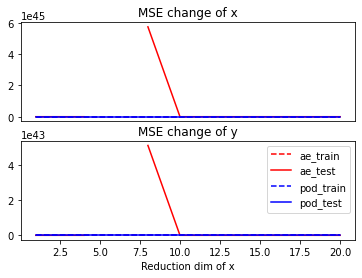

In [37]:
# plot the result
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(dim_x_reduct_list, mse_train_list_x_ae, '--r')
ax1.plot(dim_x_reduct_list, mse_test_list_x_ae, 'r')
ax1.plot(dim_x_reduct_list, mse_train_list_x_pod,'--b')
ax1.plot(dim_x_reduct_list, mse_test_list_x_pod,'b')
ax1.set_title('MSE change of x')
ax1.set_xticks([])

ax2.plot(dim_x_reduct_list, mse_train_list_y_ae, '--r', label='ae_train')
ax2.plot(dim_x_reduct_list, mse_test_list_y_ae, 'r', label='ae_test')
ax2.plot(dim_x_reduct_list, mse_train_list_y_pod, '--b', label='pod_train')
ax2.plot(dim_x_reduct_list, mse_test_list_y_pod, 'b', label='pod_test')
ax2.legend()
ax2.set_title('MSE change of y')
ax2.set_xlabel('Reduction dim of x')
